In [2]:
import tensorflow as tf


2025-01-17 18:29:16.922663: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 18:29:18.647123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737138559.537595  127250 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737138559.777937  127250 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 18:29:21.549932: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
#train_datagen= ImageDataGenerator(rescale=1./255,shear_range=0.1,zoom_range=0.1,horizontal_flip=True)
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,  # Increased rotation range
    horizontal_flip=True,
    vertical_flip=True,  # Add vertical flipping
    width_shift_range=0.2,  # Horizontal shifts
    height_shift_range=0.2,  # Vertical shifts
    brightness_range=[0.8, 1.2],  # Brightness variations
    fill_mode='nearest'
)

In [6]:
train_set= train_datagen.flow_from_directory("/mnt/c/MyEverything/PythonProjects/Recent_projects/cnn_analysis/MiniProjectCNN/Dataset/train", 
                                             target_size =(100,100),batch_size=1,class_mode='binary')

Found 202 images belonging to 2 classes.


In [7]:
test_datagen= ImageDataGenerator(rescale=1./255)
test_set= test_datagen.flow_from_directory("/mnt/c/MyEverything/PythonProjects/Recent_projects/cnn_analysis/MiniProjectCNN/Dataset/test", 
                                           target_size= (100,100), batch_size = 1, class_mode = 'binary')


Found 44 images belonging to 2 classes.


In [8]:
cnn = tf.keras.models.Sequential()

In [9]:
# First Convolutional Block
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation='relu', input_shape=[100, 100, 3]))
cnn.add(tf.keras.layers.BatchNormalization())  # Batch Normalization after Conv layer
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.25))  # Dropout after pooling to reduce overfitting

# Second Convolutional Block
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))  # Increased filters
cnn.add(tf.keras.layers.BatchNormalization())  # Batch Normalization
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.25))  # Dropout after pooling

# Third Convolutional Block
cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'))  # Added another block
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.25))

# Flatten Layer
cnn.add(tf.keras.layers.Flatten())

# Fully Connected Dense Layers
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.BatchNormalization())  # Batch Normalization in Dense layer
cnn.add(tf.keras.layers.Dropout(0.5))  # Higher Dropout rate for Dense layer

cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.BatchNormalization())  # Batch Normalization in Dense layer
cnn.add(tf.keras.layers.Dropout(0.5))

# Output Layer
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

/mnt/c/Windows/system32/tf_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1737138600.311711  127250 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 842 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [10]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
print("Class Indices:", train_set.class_indices)
print("Number of Classes:", train_set.num_classes)
print("Number of Classes:", test_set.num_classes)
print("Model Output Shape:", cnn.output_shape)
from collections import Counter
print(Counter(train_set.classes))

Class Indices: {'Defect_images': 0, 'NODefect_images': 1}
Number of Classes: 2
Number of Classes: 2
Model Output Shape: (None, 1)
Counter({1: 116, 0: 86})


In [12]:
import time
start_time = time.time()

with tf.device('/GPU:0'):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)
    history = cnn.fit(train_set, validation_data=test_set, epochs=50, callbacks=[early_stopping])
    #cnn.fit(x=train_set, validation_data=test_set, epochs=50)
    cnn.evaluate(test_set)

end_time = time.time()
print(f"Time taken for epoch: {end_time - start_time} seconds")


/mnt/c/Windows/system32/tf_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1737138604.236165  127470 service.cc:148] XLA service 0x7f80380170c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737138604.236203  127470 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-01-17 18:30:04.281046: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737138604.563034  127470 cuda_dnn.cc:529] Loaded cuDNN version 90300


  9/202 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3873 - loss: 0.6931     

I0000 00:00:1737138609.368446  127470 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


201/202 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5542 - loss: 0.6927

/mnt/c/Windows/system32/tf_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


202/202 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5544 - loss: 0.6927 - val_accuracy: 0.4318 - val_loss: 5.1081
Epoch 2/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6064 - loss: 0.6892 - val_accuracy: 0.4318 - val_loss: 47.3329
Epoch 3/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6045 - loss: 0.6866 - val_accuracy: 0.3182 - val_loss: 169.9716
Epoch 4/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5703 - loss: 0.6878 - val_accuracy: 0.2955 - val_loss: 451.6243
Epoch 5/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5735 - loss: 0.6868 - val_accuracy: 0.2955 - val_loss: 631.0511
Epoch 6/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5674 - loss: 0.6855 - val_accuracy: 0.2955 - val_loss: 665.4148
Epoch 7/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5764 - loss: 0.6844 - val_accuracy: 0.2955 - val_loss: 644.3038
Epoch 8/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6323 - loss: 0.6729 - val_acc

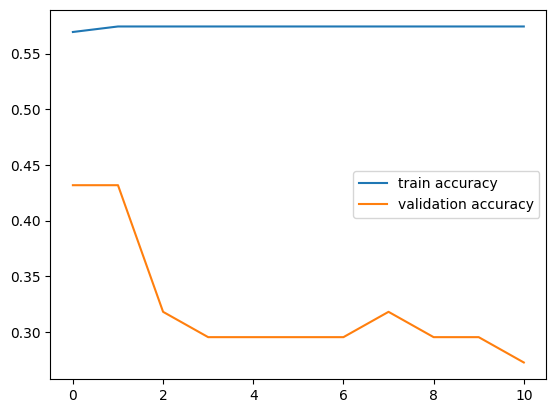

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [14]:
import numpy as np
from keras.preprocessing import image
test_images=[]

test_image = image.load_img('/mnt/c/MyEverything/PythonProjects/Recent_projects/cnn_analysis/MiniProjectCNN/Dataset/sample_img/img1.png', target_size=(100, 100))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image /= 255.0
test_images.append(test_image)

In [15]:
test_preds=[]

result = cnn.predict(test_image)
print("result:",result[0][0],end='\n\n')
predicted_class_index = 0 if result[0][0] <0.5 else 1
print('predicted class index:', predicted_class_index,'\n\n')
class_labels = {v: k for k, v in train_set.class_indices.items()}
prediction = class_labels[predicted_class_index]
print(f"Predicted class: {prediction}")
test_preds.append(prediction)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
result: 6.626406e-05

predicted class index: 0 


Predicted class: Defect_images


In [16]:
# import pickle
# with open('first_cnn_try.pkl', 'wb') as f:
#     pickle.dump(cnn, f)
#     print("Model saved!")

cnn.save('first_cnn_try.h5')

In [17]:
class_labels = {v: k for k, v in train_set.class_indices.items()}
print("Class Labels:", class_labels)


Class Labels: {0: 'Defect_images', 1: 'NODefect_images'}


In [18]:
# with open('first_cnn_try.pkl', 'rb') as f:
#     loaded_cnn = pickle.load(f)
loaded_cnn = tf.keras.models.load_model('first_cnn_try.h5')
# Use the loaded model for predictions
result = loaded_cnn.predict(test_image)
print("predicted:",result[0][0])
predicted_class_index = 0 if result[0][0] <0.5 else 1
class_labels = {v: k for k, v in train_set.class_indices.items()}
prediction = class_labels[predicted_class_index]

print(f"Predicted class: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
predicted: 6.626406e-05
Predicted class: Defect_images


In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import seaborn as sns


In [20]:
true_labels = test_set.classes


predictions = cnn.predict(test_set)
predicted_labels = [1 if pred >= 0.5 else 0 for pred in predictions.flatten()]

print(predicted_labels)


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Confusion Matrix:
 [[19  0]
 [25  0]]

Classification Report:
                  precision    recall  f1-score   support

  Defect_images       0.43      1.00      0.60        19
NODefect_images       0.00      0.00      0.00        25

       accuracy                           0.43        44
      macro avg       0.22      0.50      0.30        44
   weighted avg       0.19      0.43      0.26        44


F1 Score: 0.26
Precision: 0.19
Recall: 0.43


/mnt/c/Windows/system32/tf_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Windows/system32/tf_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Windows/system32/tf_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

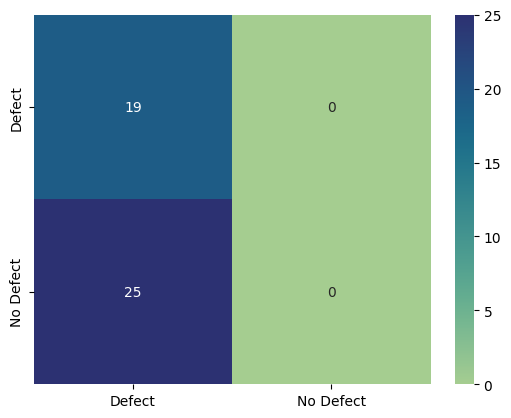

In [21]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm,annot=True,xticklabels=['Defect','No Defect'],yticklabels=['Defect','No Defect'],cmap="crest")
# Classification Report
report = classification_report(true_labels, predicted_labels, target_names=train_set.class_indices.keys())

# F1 Score, Precision, Recall
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)
print(f"\nF1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


In [22]:
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(100, 100, 3))
base_model.trainable = False  # Freeze pretrained layers

cnn2 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
cnn2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
    metrics=['accuracy']
)


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Prepare datasets
train_generator = train_datagen.flow_from_directory(
    "/mnt/c/MyEverything/PythonProjects/Recent_projects/cnn_analysis/MiniProjectCNN/Dataset/train",
    target_size=(100, 100),
    batch_size=32,
    class_mode='binary'  # Use 'categorical' for multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    "/mnt/c/MyEverything/PythonProjects/Recent_projects/cnn_analysis/MiniProjectCNN/Dataset/test",
    target_size=(100, 100),
    batch_size=32,
    class_mode='binary'
)


Found 202 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [ ]:
with tf.device('/GPU:0'):
    history = cnn.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,  # Adjust epochs based on your data size and performance
        verbose=1
    )


Epoch 1/50


In [ ]:
base_model.trainable = True  # Unfreeze layers

# Optionally, freeze earlier layers to retain low-level features
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
cnn2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
with tf.device('/GPU:0'):
    # Fine-tune the model
    history_fine_tune = cnn2.fit(
        train_generator,
        validation_data=val_generator,
        epochs=15,  # Add a few more epochs for fine-tuning
        verbose=1
    )


In [27]:
# test_generator = val_datagen.flow_from_directory(
#     '/mnt/c/MyEverything/PythonProjects/Recent_projects/cnn_analysis/MiniProjectCNN/Dataset/sample_img/',
#     target_size=(100, 100),
#     batch_size=32,
#     class_mode='binary'
# )

test_loss, test_accuracy = cnn2.evaluate(test_set, verbose=1)
print("Test Accuracy:", test_accuracy)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6834 - loss: 0.6353
Test Accuracy: 0.5681818127632141


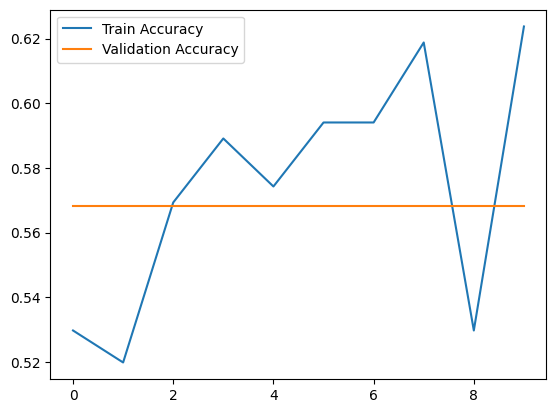

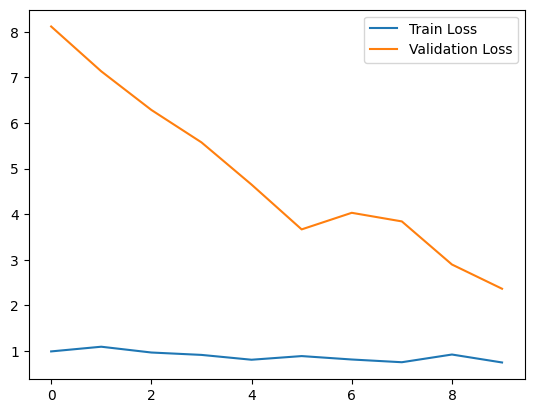

In [28]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [29]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess an image
img = image.load_img('/mnt/c/MyEverything/PythonProjects/Recent_projects/cnn_analysis/MiniProjectCNN/Dataset/sample_img/img1.png', target_size=(100, 100))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make prediction
prediction = cnn.predict(img_array)
print("Prediction:", "Positive" if prediction[0] > 0.5 else "Negative")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction: Positive
